In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os


import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("./files/Aquifer_Petrignano.csv")

### Simplifications for the sake of the tutorial ###
# Drop data before 2009 for the purpose of this tutorial
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Drop one of the target columns, so we can focus on only one target
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

# Simplify column names
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']

targets = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in targets]
from datetime import datetime, date

df.index = pd.to_datetime(df.Date, format = '%d/%m/%Y', )
df = df.drop(['Date'], axis=1)
df.head()

,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
Date,,,,,
2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3


In [2]:
df['Drainage_Volume'] = df['Drainage_Volume'].interpolate()
df['River_Hydrometry'] = df['River_Hydrometry'].interpolate()
df['Depth_to_Groundwater'] = df['Depth_to_Groundwater'].interpolate()

In [3]:
# df_downsampled = df[['Date',
#                      'Depth_to_Groundwater',
#                      'Temperature',
#                      'Drainage_Volume',
#                      'River_Hydrometry'
#                      ]].resample('7D', on='Date').mean().reset_index(drop=False)
#
# df_downsampled['Rainfall'] = df[['Date',
#                                  'Rainfall'
#                                  ]].resample('7D', on='Date').sum().reset_index(drop=False)[['Rainfall']]
uni = df['Depth_to_Groundwater']
uni

Date
2009-01-01   -31.14
2009-01-02   -31.11
2009-01-03   -31.07
2009-01-04   -31.05
2009-01-05   -31.01
              ...  
2020-06-26   -25.07
2020-06-27   -25.11
2020-06-28   -25.19
2020-06-29   -25.18
2020-06-30   -25.25
Name: Depth_to_Groundwater, Length: 4199, dtype: float64

In [16]:
df = uni
window_size = 1

In [34]:

df_as_np = uni.to_numpy()
X = []
y = []
for i in range(len(df_as_np)-1):
    row = [[a] for a in df_as_np[0:i+1]]
    X.append(row)
    label = df_as_np[i+1]
    y.append(label)



In [50]:
X[10]

[[-31.14],
 [-31.11],
 [-31.07],
 [-31.05],
 [-31.01],
 [-31.0],
 [-30.96],
 [-30.94],
 [-30.93],
 [-30.87],
 [-30.83]]

In [51]:
y[9]

-30.83

In [65]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(uni, WINDOW_SIZE)
X1.shape, y1.shape

((4194, 5, 1), (4194,))

In [66]:
X_train1, y_train1 = X1[:2000], y1[:2000]
X_val1, y_val1 = X1[2000:4000], y1[2000:4000]
X_test1, y_test1 = X1[4000:], y1[4000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((2000, 5, 1), (2000,), (2000, 5, 1), (2000,), (194, 5, 1), (194,))

In [67]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [68]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [69]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=20, callbacks=[cp1])

Epoch 1/20
59/63 [===========================>..] - ETA: 0s - loss: 510.7962 - root_mean_squared_error: 22.6008

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


63/63 [==============================] - 14s 189ms/step - loss: 497.1181 - root_mean_squared_error: 22.2961 - val_loss: 164.5772 - val_root_mean_squared_error: 12.8288
Epoch 2/20
52/63 [=======================>......] - ETA: 0s - loss: 105.6060 - root_mean_squared_error: 10.2765

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


63/63 [==============================] - 12s 198ms/step - loss: 92.2398 - root_mean_squared_error: 9.6042 - val_loss: 4.7204 - val_root_mean_squared_error: 2.1727
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 13.2566 - root_mean_squared_error: 3.6410 - val_loss: 8.6528 - val_root_mean_squared_error: 2.9416
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 11.5869 - root_mean_squared_error: 3.4040 - val_loss: 8.0579 - val_root_mean_squared_error: 2.8386
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 11.0132 - root_mean_squared_error: 3.3186 - val_loss: 7.1730 - val_root_mean_squared_error: 2.6782
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 9.7129 - root_mean_squared_error: 3.1166 - val_loss: 4.8543 - val_root_mean_squared_error: 2.2032
Epoch 7/20
55/63 [=========================>....] - ETA: 0s - loss: 5.5915 - root_mean_squared_error: 2.3646

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


63/63 [==============================] - 13s 206ms/step - loss: 5.3227 - root_mean_squared_error: 2.3071 - val_loss: 1.6262 - val_root_mean_squared_error: 1.2752
Epoch 8/20
63/63 [==============================] - ETA: 0s - loss: 2.0040 - root_mean_squared_error: 1.4156

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


63/63 [==============================] - 10s 169ms/step - loss: 2.0040 - root_mean_squared_error: 1.4156 - val_loss: 0.2756 - val_root_mean_squared_error: 0.5249
Epoch 9/20
58/63 [==========================>...] - ETA: 0s - loss: 0.6497 - root_mean_squared_error: 0.8061

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


63/63 [==============================] - 13s 211ms/step - loss: 0.6450 - root_mean_squared_error: 0.8031 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1372
Epoch 10/20
48/63 [=====================>........] - ETA: 0s - loss: 0.2169 - root_mean_squared_error: 0.4657

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


63/63 [==============================] - 12s 191ms/step - loss: 0.1924 - root_mean_squared_error: 0.4386 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1067
Epoch 11/20
52/63 [=======================>......] - ETA: 0s - loss: 0.0727 - root_mean_squared_error: 0.2697

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


63/63 [==============================] - 10s 161ms/step - loss: 0.0680 - root_mean_squared_error: 0.2607 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0997
Epoch 12/20
62/63 [============================>.] - ETA: 0s - loss: 0.0328 - root_mean_squared_error: 0.1811

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


63/63 [==============================] - 9s 143ms/step - loss: 0.0327 - root_mean_squared_error: 0.1809 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0871
Epoch 13/20
63/63 [==============================] - 0s 6ms/step - loss: 0.0211 - root_mean_squared_error: 0.1452 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1007
Epoch 14/20
63/63 [==============================] - 0s 6ms/step - loss: 0.0188 - root_mean_squared_error: 0.1371 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1109
Epoch 15/20
63/63 [==============================] - 0s 6ms/step - loss: 0.0177 - root_mean_squared_error: 0.1330 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0978
Epoch 16/20
61/63 [============================>.] - ETA: 0s - loss: 0.0124 - root_mean_squared_error: 0.1114

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


63/63 [==============================] - 10s 159ms/step - loss: 0.0125 - root_mean_squared_error: 0.1118 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0808
Epoch 17/20
63/63 [==============================] - 0s 6ms/step - loss: 0.0138 - root_mean_squared_error: 0.1177 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0860
Epoch 18/20
63/63 [==============================] - 0s 7ms/step - loss: 0.0117 - root_mean_squared_error: 0.1083 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0922
Epoch 19/20
63/63 [==============================] - 0s 7ms/step - loss: 0.0119 - root_mean_squared_error: 0.1092 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0892
Epoch 20/20
63/63 [==============================] - 0s 6ms/step - loss: 0.0103 - root_mean_squared_error: 0.1013 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0834


In [70]:
from keras.models import load_model
model1 = load_model('model1/')

In [71]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

63/63 [==============================] - 1s 2ms/step


,Train Predictions,Actuals
0,-31.211853,-31.00
1,-31.186867,-30.96
2,-31.155926,-30.94
3,-31.128780,-30.93
4,-31.107527,-30.87
...,...,...
1995,-19.883354,-19.89
1996,-19.917646,-19.88
1997,-19.924976,-19.90
1998,-19.928080,-19.94


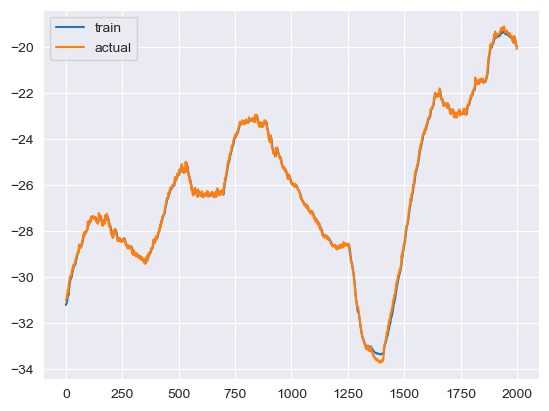

In [72]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'], label="train")
plt.plot(train_results['Actuals'], label="actual")
plt.legend(loc="upper left")

In [73]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

63/63 [==============================] - 0s 2ms/step


,Val Predictions,Actuals
0,-20.017666,-20.05
1,-20.050465,-20.05
2,-20.073231,-20.04
3,-20.070238,-20.10
4,-20.089706,-20.17
...,...,...
1995,-26.077988,-26.18
1996,-26.115921,-26.15
1997,-26.157452,-26.16
1998,-26.181942,-26.06


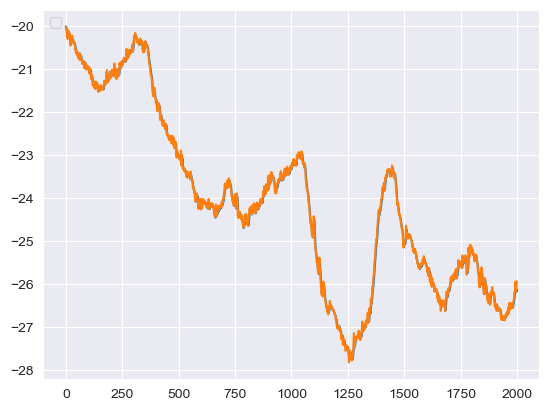

In [79]:
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])
plt.legend(loc="upper left")

In [75]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

7/7 [==============================] - 0s 3ms/step


,Test Predictions,Actuals
0,-26.064838,-25.92
1,-25.998688,-25.84
2,-25.925026,-25.86
3,-25.901310,-25.97
4,-25.931139,-26.01
...,...,...
189,-25.015877,-25.07
190,-25.067747,-25.11
191,-25.114208,-25.19
192,-25.164028,-25.18


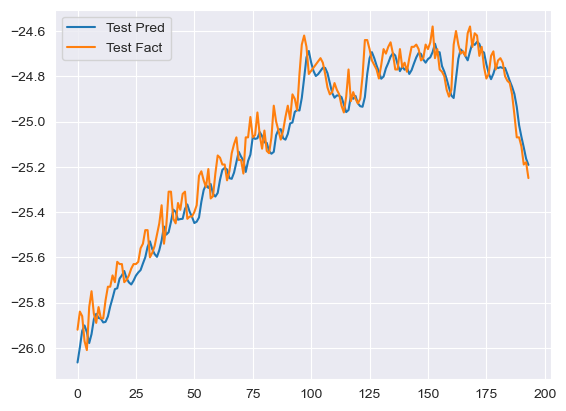

In [80]:
plt.plot(test_results['Test Predictions'], label="Test Pred")
plt.plot(test_results['Actuals'], label="Test Fact")
plt.legend()

In [77]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    return df, mse(y, predictions)

7/7 [==============================] - 0s 2ms/step


(     Predictions  Actuals
 0     -26.064838   -25.92
 1     -25.998688   -25.84
 2     -25.925026   -25.86
 3     -25.901310   -25.97
 4     -25.931139   -26.01
 ..           ...      ...
 189   -25.015877   -25.07
 190   -25.067747   -25.11
 191   -25.114208   -25.19
 192   -25.164028   -25.18
 193   -25.191530   -25.25
 
 [194 rows x 2 columns],
 0.007086166664952793)

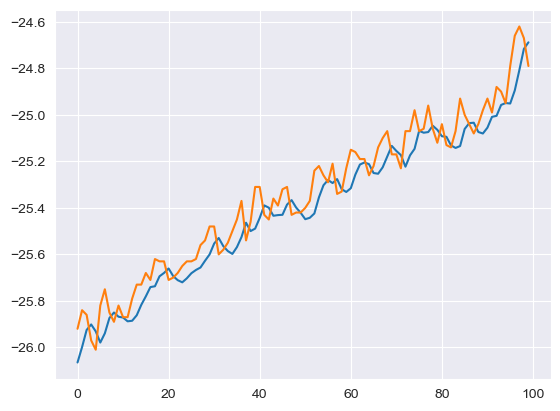

In [78]:
plot_predictions1(model1, X_test1, y_test1)